In [ ]:
# Paired test (simplest case)
#Let’s say you just want Baseline (0) vs D30 (2) comparison for each protein.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from scipy.stats import f_oneway
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests

# Load your file
df = pd.read_excel("blood_all_timepoints.xlsx")
print(" File read")

 File read


In [34]:
print(df.columns)

Index(['PatientID', 'Timepoint', 'WBC(10^9/L)', 'RBC(10^12/L)', 'HGB(g/L)',
       'HCT(L/L)', 'MCV(fL)', 'MCH(pg)', 'MCHC(g/L)', 'PLT(10^9/L)',
       'RDW-SD(fL)', 'RDW-CV(%)', 'MPV(fL)', 'P-LCR(%)', 'PCT(%)',
       'NRBC#(10^9/L)', 'NRBC%(%)', 'NEUT#(10^9/L)', 'LYMPH#(10^9/L)',
       'MONO#(10^9/L)', 'EO#(10^9/L)', 'BASO#(10^9/L)', 'NEUT%(%)',
       'LYMPH%(%)', 'MONO%(%)', 'EO%(%)', 'BASO%(%)', 'IG#(10^9/L)', 'IG%(%)',
       'RET%(%)', 'RET#(10^9/L)', 'IRF(%)', 'LFR(%)', 'MFR(%)', 'HFR(%)',
       'RET-He(pg)', 'IPF(%)', 'MicroR(%)', 'MacroR(%)', 'RBC-He(pg)',
       'Delta-He(pg)'],
      dtype='object')


In [2]:
# Median Imputation

# Columns to exclude
exclude_cols = ['PatientID', 'Timepoint']

# Step 1: Coerce feature columns to numeric (ignoring identifiers)
feature_cols = [c for c in df.columns if c not in exclude_cols]
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Step 2: Median imputation for numeric columns
numeric_cols = df[feature_cols].select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Step 3: Final checks
if df[feature_cols].isna().sum().sum() > 0:
    raise ValueError("There are still NaN values in your protein data!")

if np.isinf(df[feature_cols].values).any():
    raise ValueError("There are Inf values in your protein data!")

print(" Imputation complete, no NaNs or Inf values.")


 Imputation complete, no NaNs or Inf values.


# PCA

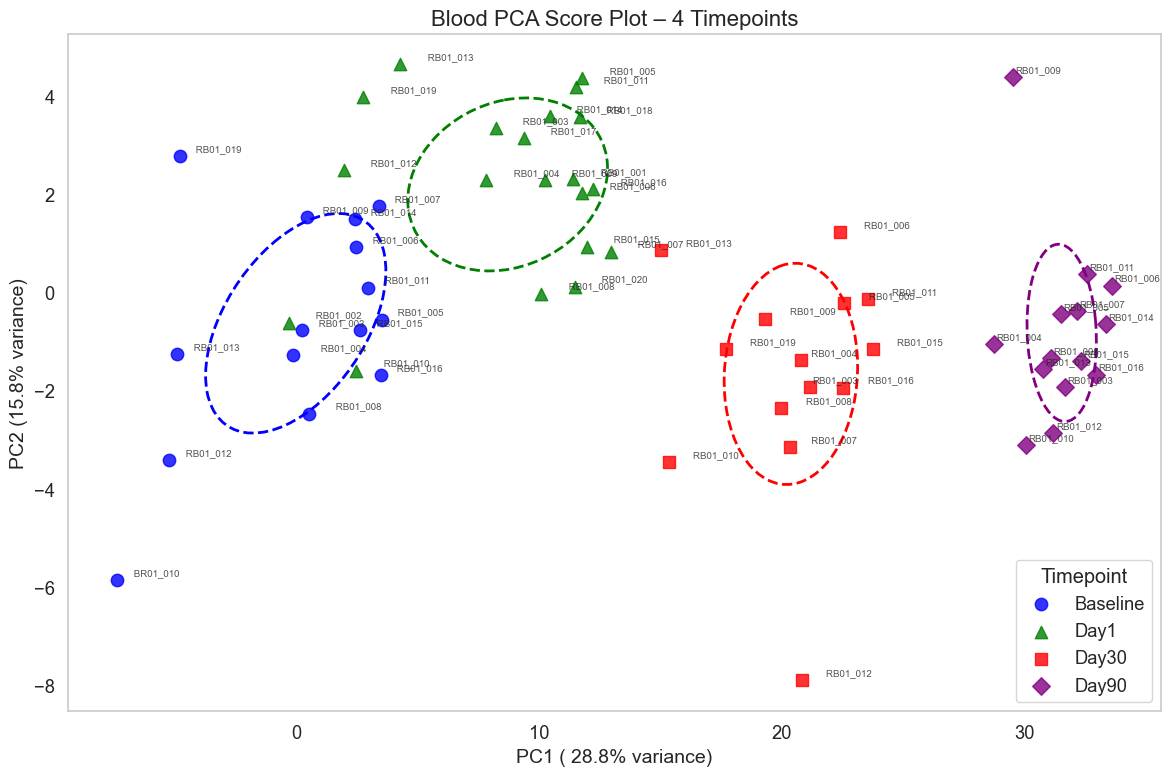

In [36]:


# --- Step 5: Scale features ---
X_scaled = StandardScaler().fit_transform(df[feature_cols])

# --- Step 6: PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]
expl_var = pca.explained_variance_ratio_ * 100

timepoint_map = {"Baseline": 0, "Day1": 1, "Day30": 2, "Day90": 3}
df['Timepoint_num'] = df['Timepoint'].map(timepoint_map)


# --- Step 7: Shift PC1 by timepoint for visualization (optional) ---
time_offsets = {0:0, 1:10, 2:20, 3:30}
df['PC1_shifted'] = df['PC1'] + df['Timepoint_num'].map(time_offsets)

# --- Step 8: Define colors, markers, labels ---
colors = {0:'blue', 1:'green', 2:'red', 3:'purple'}
markers = {0:'o', 1:'^', 2:'s', 3:'D'}
labels = {0:'Baseline', 1:'Day1', 2:'Day30', 3:'Day90'}

# --- Step 9: Plot PCA ---
plt.figure(figsize=(12,8))

for t in sorted(df['Timepoint_num'].unique()):
    subset = df[df['Timepoint_num']==t]
    plt.scatter(subset['PC1_shifted'], subset['PC2'],
                color=colors[t], marker=markers[t], s=80,
                alpha=0.8, label=labels[t])

    # Draw ellipse (1 std)
    cov = np.cov(subset[['PC1_shifted','PC2']].T)
    mean = subset[['PC1_shifted','PC2']].mean().values
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:,order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2*np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[t], fc='none', lw=2, ls='--')
    plt.gca().add_patch(ellipse)

# Connect same SampleID across timepoints and annotate
for sample_id in df['PatientID'].unique():
    sub = df[df['PatientID']==sample_id].sort_values('Timepoint_num')
    # ❌ REMOVE THIS LINE (this draws the connecting line)
    #plt.plot(sub['PC1_shifted'], sub['PC2'], color='gray', alpha=0.3, linewidth=1)
    
    for _, row in sub.iterrows():
        plt.text(row['PC1_shifted']+0.1, row['PC2']+0.1, row['PatientID'],
                 fontsize=7, alpha=0.8)

plt.xlabel(f'PC1 ( {expl_var[0]:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({expl_var[1]:.1f}% variance)', fontsize=14)
plt.title('Blood PCA Score Plot – 4 Timepoints', fontsize=16)
plt.legend(title="Timepoint")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
no line needed

# ANNOVA

In [ ]:
#!! need to riun the 1st df thn 

In [23]:
# ANNOVA 

✅ Selected top 13 markers for heatmap: ['NEUT%(%)', 'EO%(%)', 'NEUT#(10^9/L)', 'LYMPH%(%)', 'WBC(10^9/L)', 'EO#(10^9/L)', 'BASO%(%)', 'MONO#(10^9/L)', 'LYMPH#(10^9/L)', 'IG#(10^9/L)', 'HCT(L/L)', 'RBC(10^12/L)', 'HGB(g/L)']


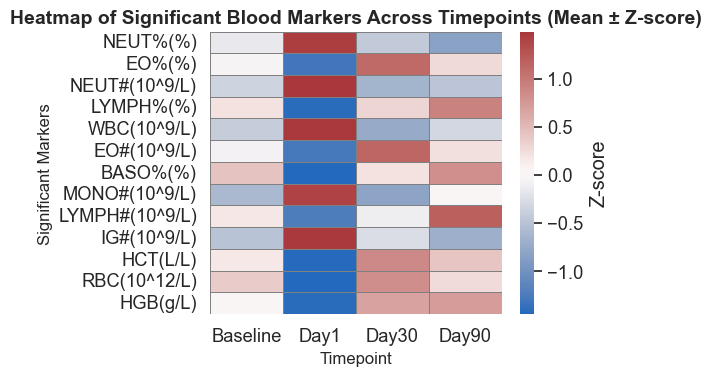


 Heatmap saved as PNG


In [3]:


# ----------------------------
# STEP 1 — Melt to long format
# ----------------------------
df_long = df.melt(id_vars=['PatientID', 'Timepoint'],
                  value_vars=feature_cols,
                  var_name='Marker',
                  value_name='Value')

# ----------------------------
# STEP 2 — ANOVA for all markers
# ----------------------------
anova_results = []

markers = df_long['Marker'].unique()
for marker in markers:
    sub = df_long[df_long['Marker'] == marker]
    groups = []
    timepoints = sorted(sub['Timepoint'].unique())
    
    for tp in timepoints:
        vals = sub[sub['Timepoint'] == tp]['Value'].dropna()
        if len(vals) > 1 and np.var(vals) > 0:
            groups.append(vals)
    
    if len(groups) < 2:
        anova_results.append({'Marker': marker, 'F-stat': None, 'p-value': None})
        continue

    try:
        f_stat, p_val = f_oneway(*groups)
    except:
        f_stat, p_val = None, None

    anova_results.append({'Marker': marker, 'F-stat': f_stat, 'p-value': p_val})

anova_df = pd.DataFrame(anova_results)
anova_df['Significant'] = anova_df['p-value'] < 0.05

# ----------------------------
# STEP 3 — Filter top N significant markers
# ----------------------------
anova_df_sorted = anova_df.sort_values('p-value')
top_n = 13
sig_markers = anova_df_sorted['Marker'].head(top_n).tolist()
print(f"✅ Selected top {top_n} markers for heatmap: {sig_markers}")

# ----------------------------
# STEP 4 — Prepare heatmap data (mean per timepoint)
# ----------------------------
heatmap_data = df.groupby('Timepoint')[sig_markers].mean().T  # rows=markers, cols=timepoints

# Standardize by row (z-score)
heatmap_data_z = heatmap_data.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# ----------------------------
# STEP 5 — Plot heatmap
# ----------------------------
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(6, max(4, 0.3 * len(sig_markers))))

# Diverging colormap
sns.heatmap(
    heatmap_data_z,
    cmap="vlag",          # blue-white-red
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Z-score'},
    yticklabels=True,
    xticklabels=timepoints
)
plt.xlabel("Timepoint", fontsize=12)
plt.ylabel("Significant Markers", fontsize=12)
plt.title("Heatmap of Significant Blood Markers Across Timepoints (Mean ± Z-score)", fontsize=14, fontweight="bold")
plt.tight_layout()

# ----------------------------
# STEP 6 — Save figure
# ----------------------------
plt.savefig("anova_significant_heatmap_blood.png", dpi=300, bbox_inches="tight")
plt.show(block=True)

print("\n Heatmap saved as PNG")


In [82]:
# Count number of significant markers
num_significant = anova_df['Significant'].sum()
print(f" Number of significant markers (p < 0.05): {num_significant}")


 Number of significant markers (p < 0.05): 13


# show upregulated vs downregulated blood markers across timepoints

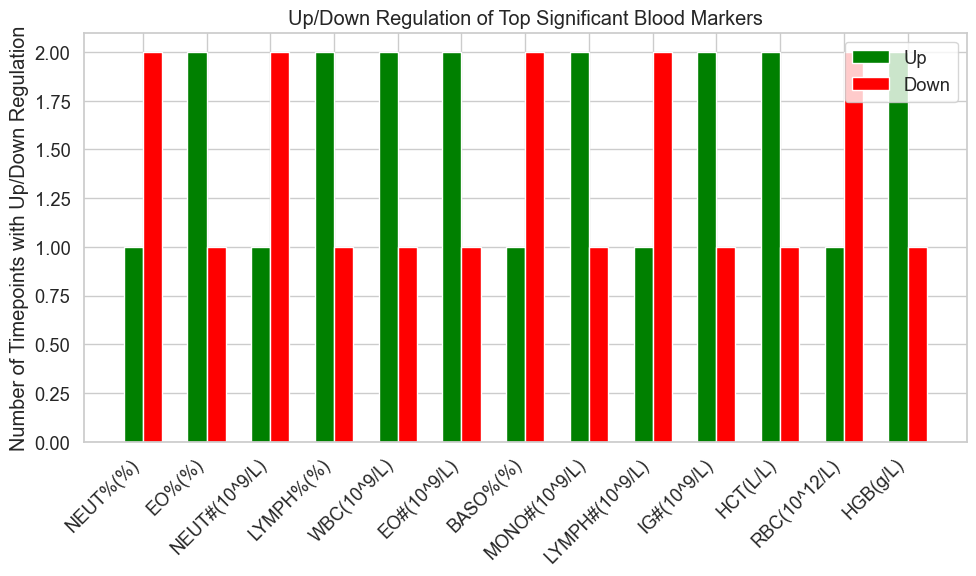

In [83]:

# Step 1 — Compute mean per timepoint
# ----------------------------
mean_tp = df.groupby('Timepoint')[sig_markers].mean()

# ----------------------------
# Step 2 — Compute log2 fold change relative to baseline
# ----------------------------
baseline = mean_tp.loc['Baseline']  # adjust name if different
lfc = mean_tp.div(baseline)  # fold change
lfc = np.log2(lfc)  # log2 fold change

# ----------------------------
# Step 3 — Identify up/down regulated markers
# ----------------------------
threshold = 0  # log2 fold change >0 up, <0 down
up_markers = (lfc.iloc[1:] > threshold).sum(axis=0)  # counts per marker across timepoints excluding baseline
down_markers = (lfc.iloc[1:] < threshold).sum(axis=0)

# ----------------------------
# Step 4 — Plot bar chart for up/down markers
# ----------------------------
plt.figure(figsize=(10,6))
markers_idx = np.arange(len(sig_markers))

plt.bar(markers_idx - 0.15, up_markers[sig_markers], width=0.3, color='green', label='Up')
plt.bar(markers_idx + 0.15, down_markers[sig_markers], width=0.3, color='red', label='Down')

plt.xticks(markers_idx, sig_markers, rotation=45, ha='right')
plt.ylabel("Number of Timepoints with Up/Down Regulation")
plt.title("Up/Down Regulation of Top Significant Blood Markers")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\mondalsy\AppData\Local\Temp\ipykernel_24692\170372309.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
C:\Users\mondalsy\AppData\Local\Temp\ipykernel_24692\170372309.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
C:\Users\mondalsy\AppData\Local\Temp\ipykernel_24692\170372309.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
C:\Users\mondalsy\AppData\Local\Temp\ipykernel_24692\170372309.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
C:\Users\mondalsy\AppDat

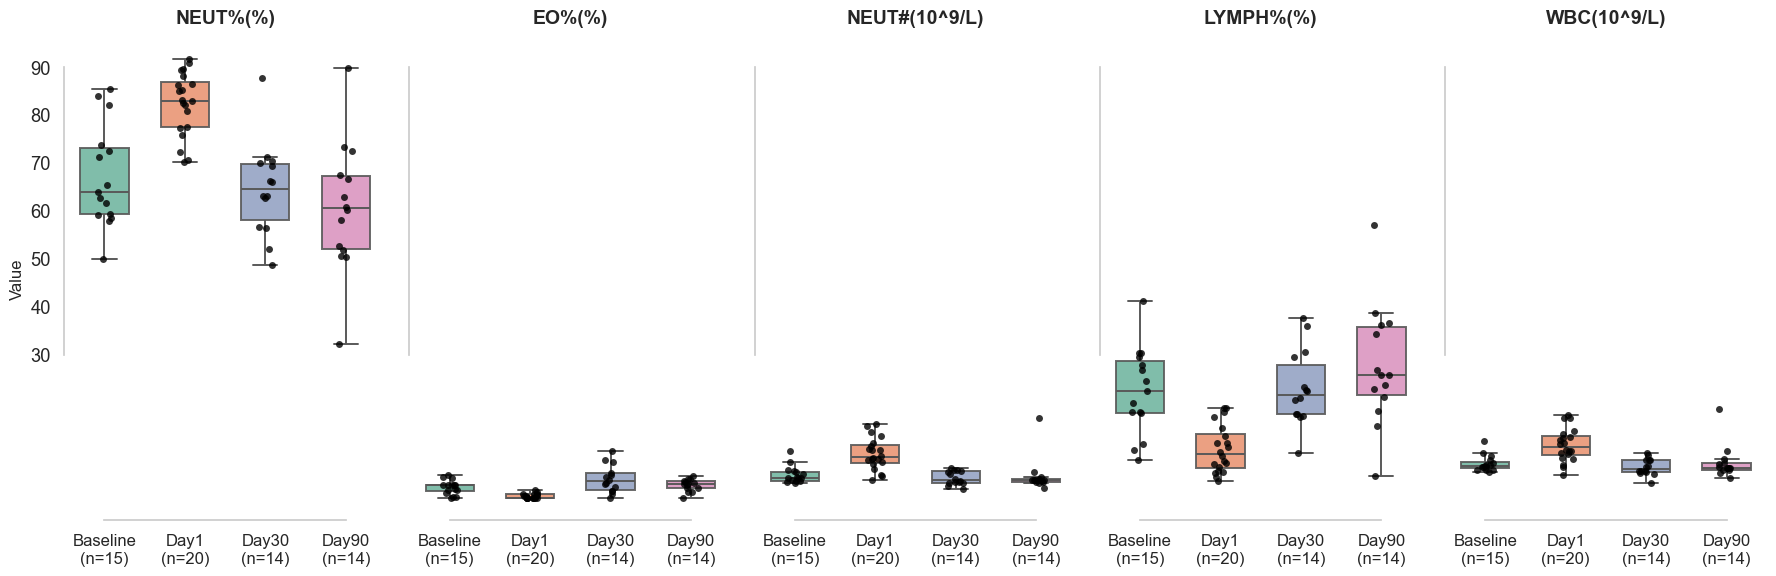

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Step 0 — Select top 5 markers
# ----------------------------
top5_markers = sig_markers[:5]  # assuming sig_markers from previous ANOVA
palette = sns.color_palette("Set2", n_colors=len(df['Timepoint'].unique()))

# ----------------------------
# Step 1 — Compute sample counts per timepoint for labels
# ----------------------------
group_counts = df.groupby('Timepoint')['PatientID'].count().to_dict()

# ----------------------------
# Step 2 — Plot boxplots for each marker
# ----------------------------
fig, axes = plt.subplots(1, len(top5_markers), figsize=(18, 6), sharey=True)

for ax, marker in zip(axes, top5_markers):
    plot_df = df[['PatientID', 'Timepoint', marker]].copy()
    plot_df = plot_df.rename(columns={marker: 'Value'})

    # Boxplot
    sns.boxplot(
        data=plot_df, x='Timepoint', y='Value',
        hue='Timepoint', dodge=False,
        palette=palette, width=0.6, fliersize=0,
        boxprops=dict(alpha=0.9), linewidth=1.4, ax=ax,
        legend=False
    )

    # Overlay individual points
    sns.stripplot(
        data=plot_df, x='Timepoint', y='Value',
        color='black', dodge=False,
        size=5, jitter=True, alpha=0.8, ax=ax,
        legend=False
    )

    # Axis & title
    ax.set_title(marker, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("", fontsize=12)
    if ax == axes[0]:
        ax.set_ylabel("Value", fontsize=12)
    else:
        ax.set_ylabel("")

    # Add group labels with n
    new_labels = [f"{tp}\n(n={group_counts[tp]})" for tp in plot_df['Timepoint'].unique()]
    ax.set_xticklabels(new_labels, fontsize=12)

    # Clean aesthetic
    sns.despine(ax=ax, trim=True)
    ax.grid(False)

plt.tight_layout()
plt.show()


# PCA using only the significant markers from your ANOVA

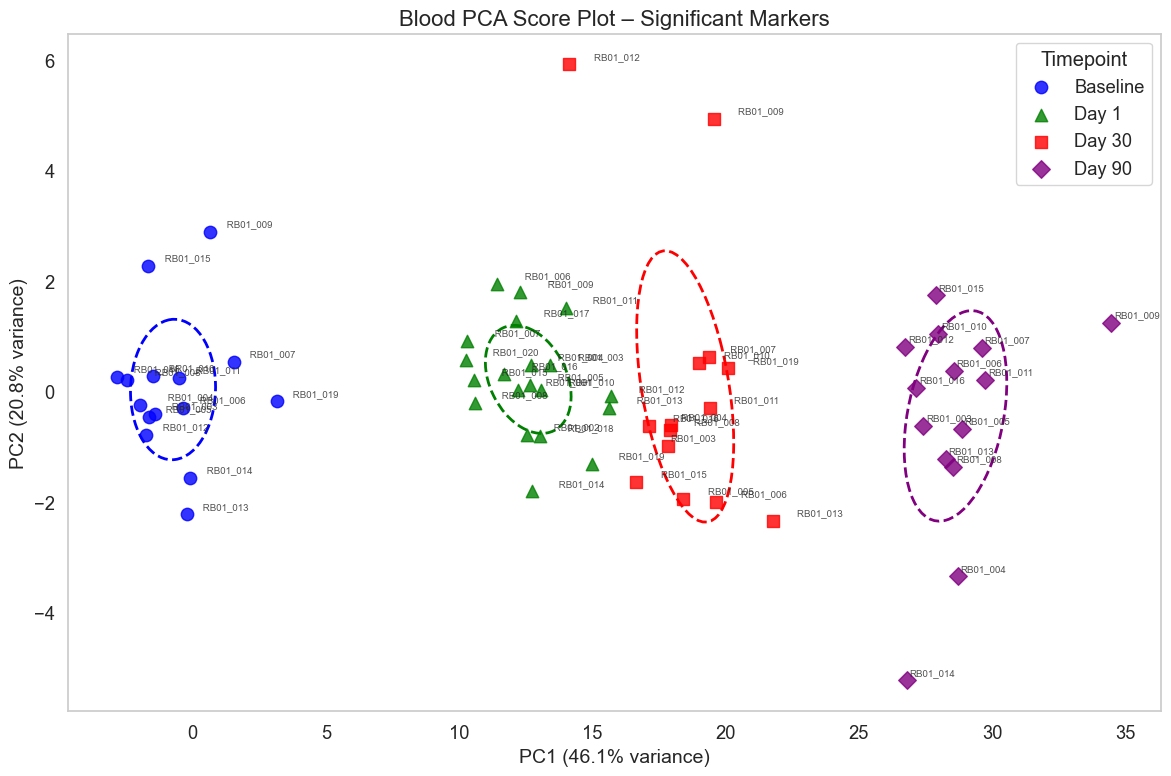

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd

# ----------------------------
# STEP 1 — Select significant features
# ----------------------------
sig_features = anova_df.loc[anova_df['Significant'], 'Marker'].tolist()
df_sig = df[['PatientID', 'Timepoint'] + sig_features].copy()

# Ensure all numeric
for col in sig_features:
    df_sig[col] = pd.to_numeric(df_sig[col], errors='coerce')

# ----------------------------
# STEP 2 — Scale features
# ----------------------------
X_scaled = StandardScaler().fit_transform(df_sig[sig_features])

# ----------------------------
# STEP 3 — PCA
# ----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_sig['PC1'] = X_pca[:,0]
df_sig['PC2'] = X_pca[:,1]
expl_var = pca.explained_variance_ratio_ * 100

# Optional: shift PC1 for visualization
time_offsets = {'Baseline': 0, 'Day1': 10, 'Day30': 20, 'Day90': 30}
df_sig['PC1_shifted'] = df_sig['PC1'] + df_sig['Timepoint'].map(time_offsets)

# Colors & markers keyed by Timepoint strings
colors = {'Baseline':'blue', 'Day1':'green', 'Day30':'red', 'Day90':'purple'}
markers = {'Baseline':'o', 'Day1':'^', 'Day30':'s', 'Day90':'D'}
labels = {'Baseline':'Baseline', 'Day1':'Day 1', 'Day30':'Day 30', 'Day90':'Day 90'}

# ----------------------------
# STEP 4 — Plot PCA
# ----------------------------
plt.figure(figsize=(12,8))

for t in sorted(df_sig['Timepoint'].unique()):
    subset = df_sig[df_sig['Timepoint']==t]
    plt.scatter(subset['PC1_shifted'], subset['PC2'],
                color=colors[t], marker=markers[t], s=80,
                alpha=0.8, label=labels[t])
    
    # Draw ellipse (1 std)
    cov = np.cov(subset[['PC1_shifted','PC2']].T)
    mean = subset[['PC1_shifted','PC2']].mean().values
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:,order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2*np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[t], fc='none', lw=2, ls='--')
    plt.gca().add_patch(ellipse)

# Annotate each sample (PatientID)
for sample_id in df_sig['PatientID'].unique():
    sub = df_sig[df_sig['PatientID']==sample_id].sort_values('Timepoint')
    for _, row in sub.iterrows():
        plt.text(row['PC1_shifted']+0.1, row['PC2']+0.1, row['PatientID'],
                 fontsize=7, alpha=0.8)

plt.xlabel(f'PC1 ({expl_var[0]:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({expl_var[1]:.1f}% variance)', fontsize=14)
plt.title('Blood PCA Score Plot – Significant Markers', fontsize=16)
plt.legend(title="Timepoint")
plt.grid(False)
plt.tight_layout()
plt.show()


Shapiro–Wilk normality test for each blood marker across all samples

In [65]:
# run df

# Columns to exclude
exclude_cols = ['PatientID', 'Timepoint']

# Feature columns
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Store results
normality_results = []

for marker in feature_cols:
    data = df[marker].dropna()  # remove NaNs
    if len(data) < 3:  # Shapiro requires at least 3 values
        normality_results.append({'Marker': marker, 'W-stat': np.nan, 'p-value': np.nan})
        continue
    
    try:
        W, p_val = shapiro(data)
    except Exception as e:
        W, p_val = np.nan, np.nan
    
    normality_results.append({'Marker': marker, 'W-stat': W, 'p-value': p_val})

# Convert to DataFrame
normality_df = pd.DataFrame(normality_results)

# Add flag for normality
alpha = 0.05
normality_df['Normal'] = normality_df['p-value'] > alpha

# Display results
#print(normality_df)
print(" done")


 done


C:\Miniforge-all\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


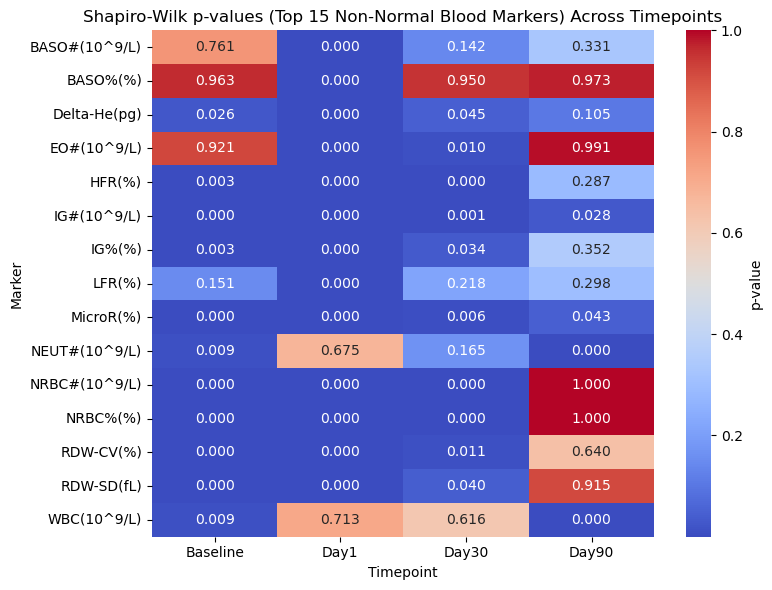

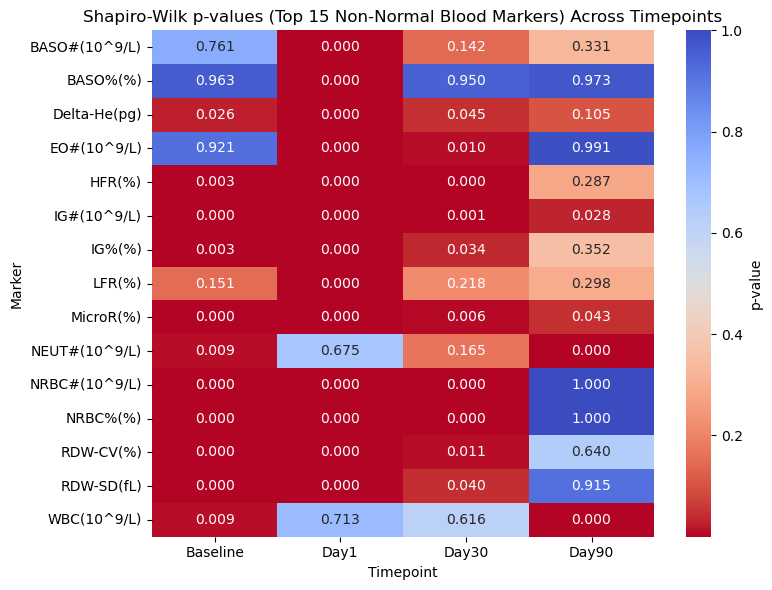

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Step 0 — Ensure column names are clean
# ----------------------------
df.columns = df.columns.str.strip()

# ----------------------------
# Step 1 — Feature columns
# ----------------------------
exclude_cols = ['PatientID', 'Timepoint']
feature_cols = [c for c in df.columns if c not in exclude_cols]
timepoints = df['Timepoint'].unique()

# ----------------------------
# Step 2 — Shapiro-Wilk per marker per timepoint
# ----------------------------
normality_results = []

for marker in feature_cols:
    for tp in timepoints:
        data = df.loc[df['Timepoint'] == tp, marker].dropna()
        if len(data) < 3:
            W, p_val = np.nan, np.nan
        else:
            W, p_val = shapiro(data)
        normality_results.append({'Marker': marker, 'Timepoint': tp, 'W-stat': W, 'p-value': p_val})

normality_df = pd.DataFrame(normality_results)
normality_df['Normal'] = normality_df['p-value'] > 0.05

# ----------------------------
# Step 3 — Select top 15 non-normal markers
# ----------------------------
# Aggregate by minimum p-value across timepoints
min_p = normality_df.groupby('Marker')['p-value'].min().sort_values()
top15_markers = min_p.head(15).index.tolist()

# Filter heatmap data
heatmap_data = normality_df[normality_df['Marker'].isin(top15_markers)]

# Ensure 'Timepoint' column exists
if 'Timepoint' not in heatmap_data.columns:
    raise ValueError("Column 'Timepoint' not found in normality results!")

# Pivot for heatmap: rows = Marker, columns = Timepoint
heatmap_data = heatmap_data.pivot(index='Marker', columns='Timepoint', values='p-value')

# ----------------------------
# Step 4 — Plot heatmap
# ----------------------------

plt.figure(figsize=(8, max(4, 0.4*len(top15_markers))))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="coolwarm_r",     # 🔥 reversed colormap (low = red, high = blue)
    cbar_kws={'label':'p-value'}
)
plt.title('Shapiro-Wilk p-values (Top 15 Non-Normal Blood Markers) Across Timepoints')
plt.ylabel('Marker')
plt.xlabel('Timepoint')
plt.tight_layout()
plt.show()


In [60]:
print(df.columns.tolist())


['PatientID', 'Timepoint', 'WBC(10^9/L)', 'RBC(10^12/L)', 'HGB(g/L)', 'HCT(L/L)', 'MCV(fL)', 'MCH(pg)', 'MCHC(g/L)', 'PLT(10^9/L)', 'RDW-SD(fL)', 'RDW-CV(%)', 'MPV(fL)', 'P-LCR(%)', 'PCT(%)', 'NRBC#(10^9/L)', 'NRBC%(%)', 'NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'MONO#(10^9/L)', 'EO#(10^9/L)', 'BASO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'MONO%(%)', 'EO%(%)', 'BASO%(%)', 'IG#(10^9/L)', 'IG%(%)', 'RET%(%)', 'RET#(10^9/L)', 'IRF(%)', 'LFR(%)', 'MFR(%)', 'HFR(%)', 'RET-He(pg)', 'IPF(%)', 'MicroR(%)', 'MacroR(%)', 'RBC-He(pg)', 'Delta-He(pg)']


In [ ]:
# Differential Blood Biomarker Analysis: An example 


In [75]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, friedmanchisquare
from statsmodels.stats.multitest import multipletests

# ----------------------------
# Step 0 — Setup
# ----------------------------
exclude_cols = ['PatientID', 'Timepoint']
feature_cols = [c for c in df.columns if c not in exclude_cols]
timepoints = df['Timepoint'].unique()

# ----------------------------
# Step 1 — Initialize results
# ----------------------------
anova_results = []

# ----------------------------
# Step 2 — Run ANOVA (or Friedman if non-normal) per marker
# ----------------------------
for marker in feature_cols:
    # Prepare groups per timepoint
    groups = [df.loc[df['Timepoint'] == tp, marker].dropna() for tp in timepoints]
    
    # Only run if each group has >1 sample
    if all(len(g) > 1 for g in groups):
        try:
            f_stat, p_val = f_oneway(*groups)  # One-way ANOVA
        except:
            f_stat, p_val = np.nan, np.nan
    else:
        f_stat, p_val = np.nan, np.nan
    
    anova_results.append({'Marker': marker, 'F-stat': f_stat, 'p-value': p_val})

anova_df = pd.DataFrame(anova_results)

# ----------------------------
# Step 3 — FDR correction
# ----------------------------
anova_df['p_adj'] = multipletests(anova_df['p-value'], method='fdr_bh')[1]

# ----------------------------
# Step 4 — Flag significant markers
# ----------------------------
alpha = 0.05
anova_df['Significant'] = anova_df['p_adj'] < alpha

# ----------------------------
# Step 5 — Output top markers
# ----------------------------
top_markers = anova_df.sort_values('p_adj').head(15)
print(top_markers)


           Marker    F-stat   p-value  p_adj  Significant
0     WBC(10^9/L)  9.746613  0.000026    NaN        False
1    RBC(10^12/L)  3.159497  0.031169    NaN        False
2        HGB(g/L)  2.792682  0.048139    NaN        False
3        HCT(L/L)  3.398434  0.023519    NaN        False
4         MCV(fL)  0.392869  0.758575    NaN        False
5         MCH(pg)  0.753027  0.524990    NaN        False
6       MCHC(g/L)  1.159769  0.332772    NaN        False
7     PLT(10^9/L)  0.324588  0.807559    NaN        False
8      RDW-SD(fL)  1.278116  0.290230    NaN        False
9       RDW-CV(%)  0.807630  0.494682    NaN        False
10        MPV(fL)       NaN       NaN    NaN        False
11       P-LCR(%)       NaN       NaN    NaN        False
12         PCT(%)       NaN       NaN    NaN        False
13  NRBC#(10^9/L)  1.173120  0.327858    NaN        False
14       NRBC%(%)  1.636859  0.190738    NaN        False


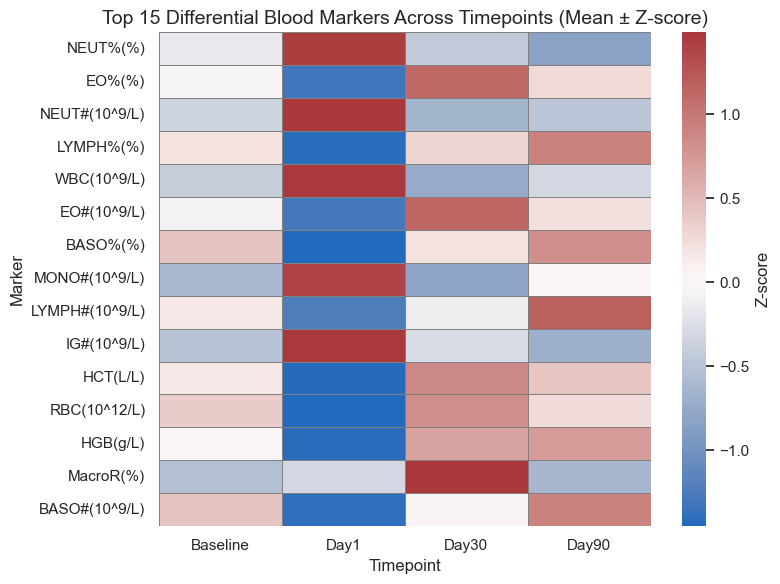

In [76]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Step 0 — Setup
# ----------------------------
exclude_cols = ['PatientID', 'Timepoint']
feature_cols = [c for c in df.columns if c not in exclude_cols]
timepoints = df['Timepoint'].unique()

# ----------------------------
# Step 1 — Run ANOVA per marker
# ----------------------------
anova_results = []

for marker in feature_cols:
    groups = [df.loc[df['Timepoint']==tp, marker].dropna() for tp in timepoints]
    if all(len(g) > 1 for g in groups):
        try:
            f_stat, p_val = f_oneway(*groups)
        except:
            f_stat, p_val = np.nan, np.nan
    else:
        f_stat, p_val = np.nan, np.nan
    anova_results.append({'Marker': marker, 'F-stat': f_stat, 'p-value': p_val})

anova_df = pd.DataFrame(anova_results)

# ----------------------------
# Step 2 — Select top 15 markers by p-value
# ----------------------------
top15_markers = anova_df.sort_values('p-value').head(15)['Marker'].tolist()

# ----------------------------
# Step 3 — Prepare heatmap data (mean per timepoint)
# ----------------------------
heatmap_data = df.groupby('Timepoint')[top15_markers].mean().T  # rows=markers, cols=timepoints

# Optional: z-score normalization per marker
heatmap_data_z = heatmap_data.apply(lambda x: (x - x.mean())/x.std(), axis=1)

# ----------------------------
# Step 4 — Plot heatmap
# ----------------------------
plt.figure(figsize=(8, max(4, 0.4*len(top15_markers))))
sns.heatmap(
    heatmap_data_z,
    cmap='vlag',          # diverging colormap
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label':'Z-score'},
    yticklabels=True,
    xticklabels=True
)
plt.title('Top 15 Differential Blood Markers Across Timepoints (Mean ± Z-score)', fontsize=14)
plt.ylabel('Marker')
plt.xlabel('Timepoint')
plt.tight_layout()
plt.show()
